##### Sprintの目的
- スクラッチを通してCNNの基礎を理解する

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from decimal import Decimal, ROUND_HALF_UP

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

#np.set_printoptions(threshold=0)

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。



#### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

#### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化、正規化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape)

Using TensorFlow backend.


(48000, 784) (48000, 10)
(12000, 784) (12000, 10)


### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s + b
$$
$a_i$ : 出力される配列のi番目の値


$F$ : フィルタのサイズ


$x_{(i+s)}$ : 入力の配列の(i+s)番目の値


$w_s$ : 重みの配列のs番目の値


$b$ : バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s' = w_s - α\frac{∂L}{∂w_s}
$$

$$
b' = b - α\frac{∂L}{∂b}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配


勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。
$$
\frac{∂L}{∂w_s} = \sum_{i=0}^{N_{out} - 1}\frac{∂L}{∂a_i}x_{(i + s)}
$$
$$
\frac{∂L}{∂b} = \sum_{i=0}^{N_{out} - 1}\frac{∂L}{∂a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値


$N_{out}$ : 出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{∂L}{∂x_i} = \sum_{s=0}^{F-1}\frac{∂L}{∂a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値


ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。


全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。



#### 回答

In [3]:
class SimpleConv1d:
    def __init__(self, initializer, optimizer, S=1, P=0):
        self.w = initializer.W()
        self.b = initializer.B()
        self.optimizer = optimizer
        self.S = S
        self.P = P
    
    def forward(self, Z):
        """
        Z : 順伝播された特徴量データ
        """
        out_shape = calc_out_shape(Z, self.P, self.w, self.S)
        #indexの配列作成
        id_A = np.arange(out_shape).reshape(-1, 1)
        id_w = np.arange(len(self.w))
        id_array = id_A + id_w
        A = Z[id_array] @ self.w.T + self.b
        
        #参考
        #stride_data = np.array([X[i:i+3] for i in range(out_shape)]) 
        #A = stride_data @ self.w.T + self.b
        
        return A
    
    def backward(self, Z, dA):
        """
        Z : 順伝播された特徴量データ
        dA : 逆伝播されたAに関するLoss勾配
        """
        #indexの配列作成
        id_dA = np.arange(len(dA))
        id_w = np.arange(len(self.w))
        
        #db
        self.db = np.sum(dA, axis=0)
        
        #dw
        id_array_dw = id_dA.reshape(-1, 1) + id_w
        self.dw = dA @ Z[id_array_dw]
        
        #dZ
        id_array_dZ = id_Z - id_dA
        mask = np.where((id_array_dZ < 0) | (id_array_dZ > n_out)) # | はorの意味
        id_array_dZ[mask] = 0
        w_mask = w[id_array_dZ]
        w_mask[mask] = 0
        self.dZ = dA @ w_mask.T
        
        return self.dZ

In [4]:
def calc_out_shape(IN, P, F, S):
    """
    「入力データ、パディング、フィルタ、ストライド」を受け取り、出力データのサイズを返す
    2次元データまで対応
    """
    if IN.ndim == 1:
        out_shape = int((len(IN) + 2*P - len(F))/S + 1)
    else:
        in_h, in_w = IN.shape
        f_h, f_w = F.shape
        out_h = int((in_h + 2*P - f_h)/S + 1)
        out_w = int((in_w + 2*P - f_w)/S + 1)
        out_shape = out_h, out_w
    
    return out_shape

In [5]:
#参考
P = 0
S = 1
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
dA = np.array([10, 20])

n_out = calc_out_shape(x, P, w, S)

id_dA = np.arange(dA.shape[0])  #dA分のindexを生成
print("id_dA：\n", id_dA)
id_Z = np.arange(x.shape[0])[:,None]  #出力層分のindexを生成
print("id_Z：\n", id_Z)
id_w = np.arange(w.shape[0])[:,None]  #フィルタ数分のindexを生成
print("id_w：\n", id_w)

# dZ計算
id_array_dZ = id_Z - id_dA  #ブロードキャスト用index
print(id_array_dZ)
mask = np.where((id_array_dZ < 0) | (id_array_dZ > n_out))
print(mask)
id_array_dZ[mask] = 0
print("id_array_dZ:\n", id_array_dZ)
w_mask = w[id_array_dZ]
print("w_mask1:\n", w_mask)
w_mask[mask] = 0
print("w_mask2:\n", w_mask)
dZ = np.sum(w_mask * dA, axis = 1)
print("dZ:\n", dZ)

id_dA：
 [0 1]
id_Z：
 [[0]
 [1]
 [2]
 [3]]
id_w：
 [[0]
 [1]
 [2]]
[[ 0 -1]
 [ 1  0]
 [ 2  1]
 [ 3  2]]
(array([0, 3]), array([1, 0]))
id_array_dZ:
 [[0 0]
 [1 0]
 [2 1]
 [0 2]]
w_mask1:
 [[3 3]
 [5 3]
 [7 5]
 [3 7]]
w_mask2:
 [[3 0]
 [5 3]
 [7 5]
 [0 7]]
dZ:
 [ 30 110 170 140]


### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} = \frac{N_{in} + 2P - F}{S} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ



#### 回答

In [6]:
def calc_out_shape(IN, P, F, S):
    """
    「入力データ、パディング、フィルタ、ストライド」を受け取り、出力データのサイズを返す
    2次元データまで対応
    """
    if IN.ndim == 1:
        out_shape = int((len(IN) + 2*P - len(F))/S + 1)
    else:
        in_h, in_w = IN.shape
        f_h, f_w = F.shape
        out_h = int((in_h + 2*P - f_h)/S + 1)
        out_w = int((in_w + 2*P - f_w)/S + 1)
        out_shape = out_h, out_w
    
    return out_shape

In [7]:
#検証（1次元データの場合）
P = 0
S = 1
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

calc_out_shape(x, P, w, S) #2

2

In [8]:
#検証(2次元データの場合)
IN = np.arange(16).reshape(4, 4)
P = 1
F = np.arange(9).reshape(3, 3)
S = 1

calc_out_shape(IN, P, F, S) #(4, 4)

(4, 4)

In [9]:
def get_out_shape(IN, f_size, S=1, P=0):
    return int((IN + 2*P - f_size) // S + 1)

### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

In [10]:
class SimpleConv1d_test:
    def __init__(self, w, b, S=1, P=0):
        self.w = w
        self.b = b
        self.S = S
        self.P = P
    
    def forward(self, Z):
        """
        Z : 順伝播された特徴量データ
        """
        out_shape = calc_out_shape(Z, self.P, self.w, self.S)
        #indexの配列作成
        id_A = np.arange(out_shape).reshape(-1, 1)
        id_w = np.arange(len(self.w))
        id_array = id_A + id_w
        A = Z[id_array] @ self.w.T + self.b
        
        #参考
        #stride_data = np.array([X[i:i+3] for i in range(out_shape)]) 
        #A = stride_data @ self.w.T + self.b
        
        return A
    
    def backward(self, Z, dA):
        """
        Z : 順伝播された特徴量データ
        dA : 逆伝播されたAに関するLoss勾配
        """
        #indexの配列作成
        id_dA = np.arange(len(dA))
        id_w = np.arange(len(self.w))
        
        #db
        self.db = np.sum(dA, axis=0)
        
        #dw
        id_array_dw = id_dA.reshape(-1, 1) + id_w
        self.dw = dA @ Z[id_array_dw]
        
        #dZ
        id_array_dZ = id_Z - id_dA
        mask = np.where((id_array_dZ < 0) | (id_array_dZ > n_out)) # | はorの意味
        id_array_dZ[mask] = 0
        w_mask = w[id_array_dZ]
        w_mask[mask] = 0
        self.dZ = dA @ w_mask.T
        
        return self.db, self.dw, self.dZ

#### 回答

In [11]:
#検証
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
dA = np.array([10, 20])

test = SimpleConv1d_test(w, b)
test.forward(x)

array([35, 50])

In [12]:
test.backward(x, dA)

(30, array([ 50,  80, 110]), array([ 30, 110, 170, 140]))

diverの例と一致している

### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。  
例えば以下の入力があった場合、

In [13]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
display(x)
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
display(w)
b = np.array([1, 2, 3]) # （出力チャンネル数）
display(b)

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

array([1, 2, 3])

出力は以下のようになる。

In [14]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
display(a)

array([[16, 22],
       [17, 23],
       [18, 24]])

In [15]:
#魚本より

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [16]:
def im2col_1d(input_data, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 幅)の3次元配列からなる入力データ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, W = input_data.shape
    out_size = get_out_shape(W, filter_w, stride, pad)

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_w, out_size))

    for x in range(filter_w):
        x_max = x + stride * out_size
        col[:, :, x, :] = img[:, :, x:x_max:stride]

    col = col.transpose(0, 3, 1, 2)
    col = col.reshape(N * out_size, -1)
    return col


def col2im_1d(col, input_shape, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, W = input_shape
    out_size = get_out_shape(W, filter_w, stride, pad)

    col = col.reshape(N, out_size, C, filter_w).transpose(0, 2, 3, 1)
    img = np.zeros((N, C, W + 2 * pad +  stride - 1))
    for x in range(filter_w):
        x_max = x + stride * out_size
        img[:, :, x:x_max:stride] += col[:, :, x, :]

    return img[:, :, pad:W + pad]

In [17]:
# 「im2col と im2col_1d」 及び 「col2im と col2im_1d」の整合性確認

x__ = x[np.newaxis, :, np.newaxis, :]
print("x__ :\n", x__)
print(x__.shape)
print("\n")
print(im2col(x__, 1, 3))
print(col2im(im2col(x__, 1, 3), x__.shape, 1, 3))

print("-----------------------------")

x_ = x[np.newaxis, :, :]
print("x_ :\n", x_)
print(x_.shape)
print("\n")
print(im2col_1d(x_, 3))
print(col2im_1d(im2col_1d(x_, 3), x_.shape, 3))

x__ :
 [[[[1 2 3 4]]

  [[2 3 4 5]]]]
(1, 2, 1, 4)


[[1. 2. 3. 2. 3. 4.]
 [2. 3. 4. 3. 4. 5.]]
[[[[1. 4. 6. 4.]]

  [[2. 6. 8. 5.]]]]
-----------------------------
x_ :
 [[[1 2 3 4]
  [2 3 4 5]]]
(1, 2, 4)


[[1. 2. 3. 2. 3. 4.]
 [2. 3. 4. 3. 4. 5.]]
[[[1. 4. 6. 4.]
  [2. 6. 8. 5.]]]


In [18]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

def get_out_shape(IN, f_size, S=1, P=0):
    return int((IN + 2*P - f_size) // S + 1)

#### 回答

In [19]:
class Conv1d:
    def __init__(self, w, b, stride=1, pad=0):
        self.w = w
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.X =None
        self.col = None
        self.col_w = None
        
        # 重み・バイアスパラメータの勾配
        self.dw = None
        self.db = None

    def forward(self, X):

        FN, C, FL = self.w.shape #n_filters(=out_channels), n_channels, filter_length
        N, C, L = X.shape #n_samples, n_channels, n_features
        out_size = get_out_shape(L, FL, self.stride, self.pad)
        
        col = im2col_1d(X, FL, self.stride, self.pad)
        col_w = self.w.reshape(FN, -1).T

        out = col @ col_w + self.b
        out = out.reshape(N, out_size, -1).transpose(0, 2, 1)
        
        # バックワード用
        self.X = X
        self.col = col
        self.col_w = col_w
        return out


    def backward(self, dout):
        FN, C, FL = self.w.shape #n_filters, n_channels, filter_length
        dout = dout.transpose(0, 2, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dw = self.col.T @ dout
        self.dw = self.dw.transpose(1, 0).reshape(FN, C, FL)
        
        dcol = dout @ self.col_w.T
        dx = col2im_1d(dcol, self.X.shape, FL, self.stride, self.pad)
        return dx

In [20]:
X = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]])
test = Conv1d(w, b)
print(test.forward(X))
print(test.forward(X).shape)

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
(1, 3, 2)


In [21]:
#参考

class Conv1d_:
    def __init__(self, w, b, S=1, P=0):
        self.w = w
        self.b = b
        self.S = S
        self.P = P
    
    def forward(self, Z):
        self.out_shape = calc_out_shape(Z[0], self.P, self.w[0][0], self.S)
        
        self.Z = Z
        
        #格納用
        A = np.zeros((self.w.shape[0], self.out_shape))
        
        for i in range(self.w.shape[0]):
            for j in range(self.Z.shape[0]):
                for s in range(self.out_shape):
                    A[i, j] = A[i, j] + np.dot(self.Z[j, s: s+self.w.shape[2]], self.w[i, j])
                    
        A = A + self.b.reshape(-1, 1)

        return A

In [22]:
test2 = Conv1d_(w, b)
test2.forward(x)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

diverの例と一致している

### 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


[numpy.pad — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

### 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

### 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

### 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [23]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        
    def forward(self, X):
        self.X = X
        out = np.dot(self.X, self.w) + self.b
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.w.T)
        self.dw = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0, keepdims=True)
        
        # 重みとバイアスの更新
        self = self.optimizer.update(self)
        return dX
    
##########################################
class Conv1d:
    def __init__(self, initializer, optimizer, stride=1, pad=0):
        self.w = initializer.w(n_in=1, n_out=1, fillter_size=700)
        self.b = initializer.b(n_out=1)
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.X =None
        self.col = None
        self.col_w = None
        
        # 重み・バイアスパラメータの勾配
        self.dw = None
        self.db = None

    def forward(self, X):
        X_ = X[:, np.newaxis, :]
        #print(X_.shape)
        FN, C, FL = self.w.shape #n_filters(=out_channels), n_channels, filter_length
        N, C, L = X_.shape #n_samples, n_channels, n_features
        out_size = get_out_shape(L, FL, self.stride, self.pad)
        
        col = im2col_1d(X_, FL, self.stride, self.pad)
        col_w = self.w.reshape(FN, -1).T
        
#         print(col.shape)
#         print(col_w.shape)
#         print((col@col_w).shape)
#         print((col@col_w + self.b).shape)
        
        out = col @ col_w + self.b
        out = out.reshape(N, out_size, -1).transpose(0, 2, 1)
        #print(out.shape)
        out = out.reshape(X.shape[0], -1)
        #print(out.shape)
        
        # バックワード用
        self.X_ = X_
        self.col = col
        self.col_w = col_w
        return out


    def backward(self, dout):
        FN, C, FL = self.w.shape #n_filters, n_channels, filter_length
        dout = dout[:, np.newaxis, :]
        #print("dout", dout.shape)
        dout = dout.transpose(0, 2, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dw = self.col.T @ dout
        self.dw = self.dw.transpose(1, 0).reshape(FN, C, FL)
        
        dcol = dout @ self.col_w.T
        dx = col2im_1d(dcol, self.X_.shape, FL, self.stride, self.pad)
        
        self.optimizer.update(self)
        
        return dx

###########################
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.w = layer.w - self.lr*layer.dw
        layer.b = layer.b - self.lr*layer.db

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h_w = 0
        self.h_b = 0
        
    def update(self, layer):
        self.h_w = self.h_w + (layer.dw**2).sum()
        self.h_b = self.h_b + (layer.db**2).sum()
        
        layer.w = layer.w - self.lr*(1/np.sqrt(self.h_w) + 1e-7)*layer.dw #「1e-7」で0での除算を防ぐ
        layer.b = layer.b - self.lr*(1/np.sqrt(self.h_b) + 1e-7)*layer.db
        
#################################
class XavierInitializer:
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2)
        return B

class XavierInitializer_conv:
    def __init__(self):
        self.sigma = None
        
    def w(self, n_in, n_out, fillter_size):
        sigma = 1/np.sqrt(n_in)
        if fillter_size == None:
            w = sigma * np.random.randn(n_in, n_out) #重みの初期値(全結合層)
        else:
            w = sigma * np.random.randn(n_out, n_in, fillter_size) #重みの初期値（畳み込み層）
        return w

    def b(self, n_out):
        sigma = 1/np.sqrt(n_out)
        b = sigma * np.random.randn(n_out) #バイアスの初期値
        return b

###############################
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

##################################
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def _softmax(self, X):
        X = X - np.max(X, axis=-1, keepdims=True)
        y = np.exp(X) / np.sum(np.exp(X), axis=-1, keepdims=True)
        
        return y
    
    def forward(self, X, t):
        self.t = t
        self.y = self._softmax(X)
        self.loss = self._cross_entropy_error(self.y, self.t)
        return self.loss
    
    def _cross_entropy_error(self, y, t):     
        batch_size = y.shape[0]
        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dX = (self.y - self.t)/batch_size
        return dX

In [24]:
from collections import OrderedDict

class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr, fillter_size=3, batch_size=20, max_iter=3):
        self.fillter_size = fillter_size
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.train_loss = []
        self.test_loss = []
        
        # レイヤの生成
        initializer = XavierInitializer()
        initializer_conv = XavierInitializer_conv()
        optimizer = SGD(lr=lr)
        self.layers = OrderedDict()
        self.layers["Conv1d"] = Conv1d(initializer_conv, optimizer, pad=0, stride=1)
        self.layers["ReLU"] = Relu()
        self.layers["FC1"] = FC(85, 100, initializer, optimizer)
        self.layers["ReLU_2"] = Relu()
        self.layers["FC2"] = FC(100, 50, initializer, optimizer)
        self.layers["ReLU_3"] = Relu()
        self.layers["FC3"] = FC(50, 10, initializer, optimizer)
        self.lastLayer = Softmax()
    
    def fit(self, X, y, X_val=None, y_val=None):
        # 1エポックの繰り返し数
        iter_num = int(len(X) / self.batch_size)
            
        # エポックを複数回繰り返す
        for i_ in range(self.max_iter):
            # 損失計算用
            tmp_loss_train = []
            tmp_loss_val = []

            # 1エポック
            for j_ in range(iter_num):
                batch_mask = np.random.choice(X.shape[0], self.batch_size)
                batch_mask_val = np.random.choice(X_val.shape[0], self.batch_size)
                X_batch = X[batch_mask]
                y_batch = y[batch_mask]
                X_val_batch = X_val[batch_mask_val]
                y_val_batch = y_val[batch_mask_val]
                
                #勾配
                self.gradient(X_batch, y_batch)
                
                #更新
                loss = self.loss(X_batch, y_batch)
                tmp_loss_train.append(loss)
                if (X_val is not None) and (y_val is not None):
                    loss_test = self.loss(X_val_batch, y_val_batch)
                    tmp_loss_val.append(loss_test)
                
                #print(i_, j_)
                    
            self.train_loss.append(sum(tmp_loss_train)/len(tmp_loss_train))
            self.test_loss.append(sum(tmp_loss_val)/len(tmp_loss_val))
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        for layer in self.layers.values():
            X = layer.forward(X)
            
        pred = np.argmax(X, axis=1)
        
        return pred
    
    def loss(self, X, t):
        for layer in self.layers.values():
            X = layer.forward(X)

        return self.lastLayer.forward(X, t)

    def gradient(self, X, t):
        #forward
        self.loss(X, t)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

In [25]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化、正規化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train[:500], y_train_one_hot[:500], test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape)

(400, 784) (400, 10)
(100, 784) (100, 10)


デフォルトのデータ数だと学習に時間がかかりすぎるので、流れを確認できれば良いと思いデータ数を減らした。

In [26]:
dnn = ScratchDeepNeuralNetrowkClassifier(lr=0.1, batch_size=20, max_iter=10)
dnn.fit(X_train, y_train, X_val, y_val)

In [27]:
from sklearn.metrics import accuracy_score

y_val = np.argmax(y_val, axis=1)
y_pred = dnn.predict(X_val)

print("予測：", y_pred)
print("正答率:{}".format(accuracy_score(y_pred, y_val)))

予測： [9 9 2 6 4 8 6 6 3 3 0 3 5 7 1 3 5 5 7 6 3 4 2 8 5 5 6 4 9 6 1 6 6 1 1 1 8
 1 9 2 3 9 1 4 4 4 2 9 3 1 5 9 3 2 7 1 7 8 5 3 7 3 1 1 3 6 0 0 1 3 5 9 4 5
 0 4 4 8 0 8 3 4 9 8 7 4 5 0 7 7 7 6 0 8 2 1 5 4 3 8]
正答率:0.68


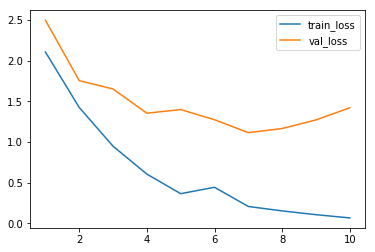

In [28]:
plt.plot(np.arange(1, len(dnn.train_loss)+1), dnn.train_loss, label="train_loss")
plt.plot(np.arange(1, len(dnn.train_loss)+1), dnn.test_loss, label="val_loss")
plt.legend()
plt.show()